In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
#from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
#import plotly.express as px
import random
#from keras.losses import SparseCategoricalCrossentropy
from collections import Counter
import seaborn as sns
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
#from keras import Layers
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

2024-12-08 16:49:34.007042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 16:49:34.359996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 16:49:34.370553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 16:49:34.413722: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1733672977.112323   12015 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733672977.298830   12015 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733672977.298897   12015 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
def fetch_image(data_folder):
    train_data = []
    test_data = []
    valid_data = []

    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }

    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")

        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)

            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue

            # Load and preprocess the image
            imgTrafficSignal = Image.open(image_path)
            #imgTrafficSignal = imgTrafficSignal.convert("L")  # Convert to grayscale
            img_width, img_height = imgTrafficSignal.size

            with open(label_path, "r") as label_file:
                label_lines = label_file.readlines()
                for line in label_lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert normalized bounding box to pixel coordinates
                    x_center_pixel = int(x_center * img_width)
                    y_center_pixel = int(y_center * img_height)
                    width_pixel = int(width * img_width)
                    height_pixel = int(height * img_height)

                    # Calculate the bounding box corners
                    x1 = max(x_center_pixel - width_pixel // 2, 0)
                    y1 = max(y_center_pixel - height_pixel // 2, 0)
                    x2 = min(x_center_pixel + width_pixel // 2, img_width)
                    y2 = min(y_center_pixel + height_pixel // 2, img_height)

                    # Crop the sign area from the image
                    cropped_img = imgTrafficSignal.crop((x1, y1, x2, y2))
                    cropped_img = cropped_img.resize((90, 90))  # Resize to 90x90

                    # Append the cropped image and class ID to the appropriate dataset
                    if split_name == "train":
                        train_data.append((np.array(cropped_img), class_id))
                    elif split_name == "test":
                        test_data.append((np.array(cropped_img), class_id))
                    elif split_name == "valid":
                        valid_data.append((np.array(cropped_img), class_id))

    return train_data, test_data, valid_data

In [4]:
# Example usage
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image(data_folder)

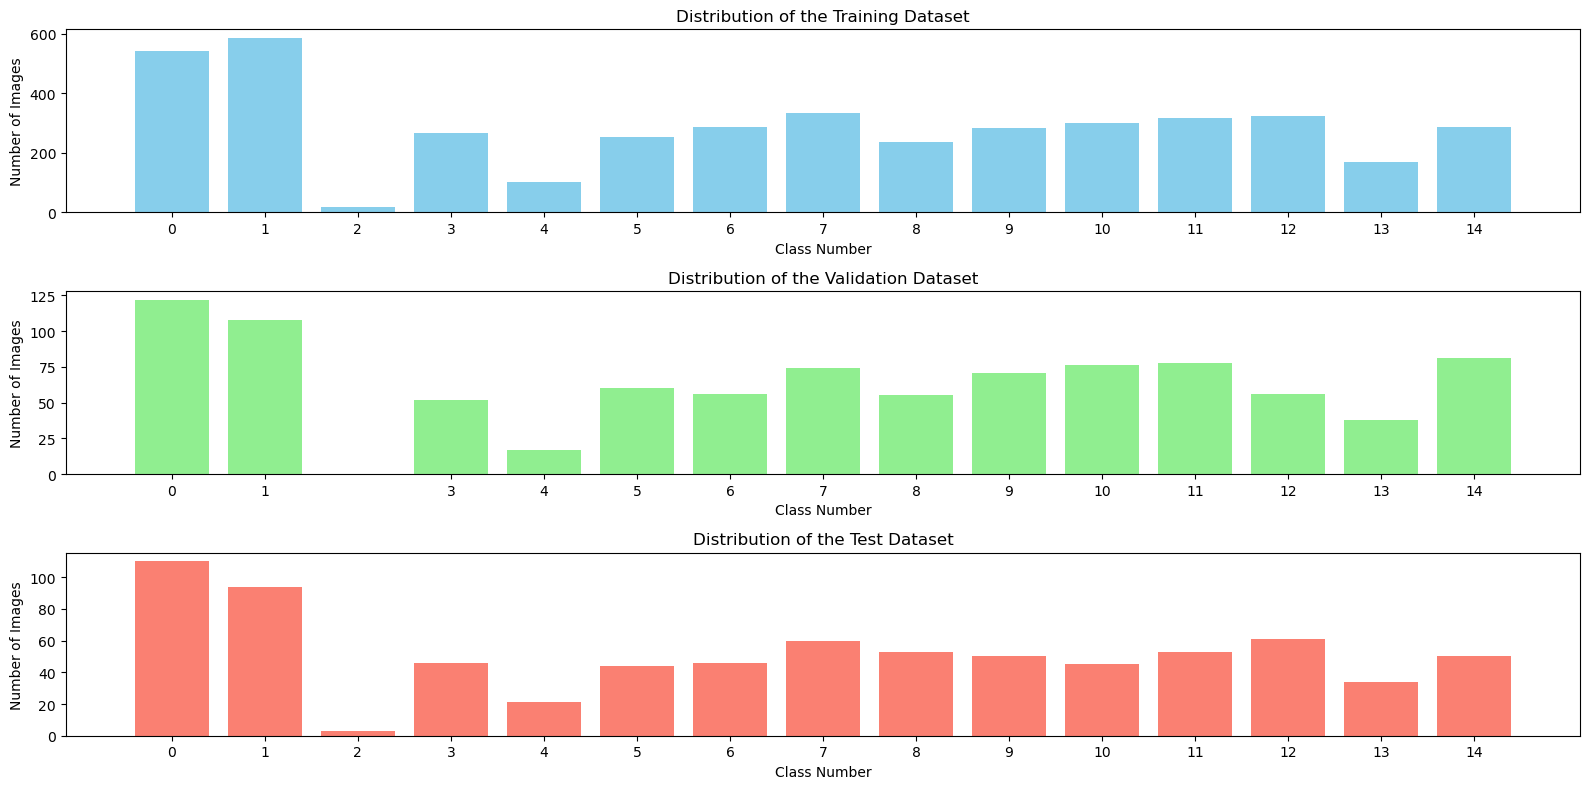

In [5]:
# Count the number of samples per class in each dataset
train_class_counts = Counter(class_id for _, class_id in train_data)
valid_class_counts = Counter(class_id for _, class_id in valid_data)
test_class_counts = Counter(class_id for _, class_id in test_data)

# Sort the counts for consistent visualization
train_classes, train_num_of_samples = zip(*sorted(train_class_counts.items()))
valid_classes, valid_num_of_samples = zip(*sorted(valid_class_counts.items()))
test_classes, test_num_of_samples = zip(*sorted(test_class_counts.items()))

# Plot the distributions for all splits
plt.figure(figsize=(16, 8))

# Training Dataset
plt.subplot(3, 1, 1)
plt.bar(train_classes, train_num_of_samples, color='skyblue')
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(train_classes)

# Validation Dataset
plt.subplot(3, 1, 2)
plt.bar(valid_classes, valid_num_of_samples, color='lightgreen')
plt.title("Distribution of the Validation Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(valid_classes)

# Test Dataset
plt.subplot(3, 1, 3)
plt.bar(test_classes, test_num_of_samples, color='salmon')
plt.title("Distribution of the Test Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(test_classes)

# Show the combined plot
plt.tight_layout()
plt.show()


In [6]:
# from keras.preprocessing.image import ImageDataGenerator
# Create an augmentation generator
# augmentation_generator = ImageDataGenerator(
#     rotation_range=15,      # Randomly rotate images in the range (degrees, 0 to 180)
#    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
#    height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
#    brightness_range=[0.8, 1.2],  # Range for brightness adjustment
#    zoom_range=0.1,         # Randomly zoom image 
#    shear_range=0.1,        # Shear intensity (shear angle in counter-clockwise direction in degrees)
#    horizontal_flip=True,   # Randomly flip inputs horizontally
#  fill_mode='nearest'     # Strategy for filling in newly created pixels
# )

In [7]:
def handle_blur_preprocessing(image):
    """
    Advanced blur handling and image sharpening techniques for a single image
    
    Args:
        image (np.ndarray): Input image
    
    Returns:
        np.ndarray: Preprocessed image with reduced blur
    """
    import cv2
    import numpy as np

    # 1. Unsharp masking for sharpening
    gaussian_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    sharpened = cv2.addWeighted(image, 1.5, gaussian_blurred, -0.5, 0)

    # 2. Edge enhancement
    kernel = np.array([
        [-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1]
    ])
    edge_enhanced = cv2.filter2D(image, -1, kernel)

    # 3. Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(image.shape) == 2:
        # Grayscale image
        clahe_image = clahe.apply(image)
    else:
        # Convert to LAB color space for better contrast enhancement
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        lab_planes = cv2.split(lab)
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab = cv2.merge(lab_planes)
        clahe_image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # 4. Selective blurring reduction
    def reduce_selective_blur(img):
        # Detect edges
        edges = cv2.Canny(img, 100, 200)

        # Create a mask of non-edge areas
        non_edge_mask = cv2.bitwise_not(edges)

        # Apply slight gaussian blur only to non-edge areas
        blurred = cv2.GaussianBlur(img, (3, 3), 0)

        # Combine original edges with blurred non-edge areas
        result = np.where(non_edge_mask[..., None], blurred, img)
        return result

    selective_blur_image = reduce_selective_blur(image)

    # Combine techniques
    final_image = np.mean([
        sharpened,
        edge_enhanced,
        clahe_image,
        selective_blur_image
    ], axis=0)

    return final_image


In [41]:
# Global variable to store augmentations
STORED_AUGMENTATIONS = []

def augmentation_pipeline(image):
    """
    Apply multiple augmentation techniques.
    Args:
        image (np.ndarray): Input image
    Returns:
        np.ndarray: Augmented image
    """
    img_tensor = tf.convert_to_tensor(image)
    
    # Random rotation
    rotation_k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    rotated = tf.image.rot90(img_tensor, k=rotation_k)
    
    # Random horizontal flip
    flipped = tf.image.random_flip_left_right(rotated)
    
    # Random brightness
    brightness_img = tf.image.random_brightness(flipped, max_delta=0.2)
    
    # Random contrast
    contrast_img = tf.image.random_contrast(brightness_img, lower=0.8, upper=1.2)
    
    # Add random noise
    noise = tf.random.normal(shape=tf.shape(contrast_img), mean=0.0, stddev=0.05)
    noisy_img = tf.clip_by_value(contrast_img + noise, 0.0, 1.0)
    
    return noisy_img.numpy()

def augment_data(train_data, augmentation_factor=3, input_shape=(90, 90, 3), max_stored_augmentations=10):
    """
    Augment data and store a limited number of augmentations globally.
    Args:
        train_data (list): List of (image, label) tuples
        augmentation_factor (int): Number of augmented versions per original image
        input_shape (tuple): Shape of input images
        max_stored_augmentations (int): Maximum number of augmentations to store globally
    Returns:
        list: Augmented dataset
    """
    global STORED_AUGMENTATIONS
    STORED_AUGMENTATIONS = []  # Reset stored augmentations

    train_features, train_labels = zip(*train_data)
    train_features = np.array(train_features, dtype=np.float32) / 255.0
    train_features = train_features.reshape(-1, *input_shape)
    train_labels = np.array(train_labels)

    augmented_features = []
    augmented_labels = []
    stored_count = 0

    for i in range(len(train_features)):
        original_img = train_features[i]
        label = train_labels[i]
        augmented_images = [original_img]  # Store the original image

        # Add the original image to the dataset
        augmented_features.append(original_img)
        augmented_labels.append(label)

        for _ in range(augmentation_factor):
            try:
                augmented_img = augmentation_pipeline(original_img)
                augmented_features.append(augmented_img)
                augmented_labels.append(label)

                if stored_count < max_stored_augmentations:
                    augmented_images.append(augmented_img)
            except Exception as e:
                print(f"Augmentation error for image {i}: {e}")

        # Store the augmentations globally
        if stored_count < max_stored_augmentations:
            STORED_AUGMENTATIONS.append((original_img, augmented_images))
            stored_count += 1

    augmented_dataset = list(zip(augmented_features, augmented_labels))
    indices = np.random.permutation(len(augmented_dataset))
    augmented_dataset = [augmented_dataset[i] for i in indices]
    
    return augmented_dataset

def visualize_stored_augmentations():
    """
    Visualize stored augmentations.
    """
    global STORED_AUGMENTATIONS

    num_images = len(STORED_AUGMENTATIONS)
    if num_images == 0:
        print("No augmentations stored.")
        return

    fig, axes = plt.subplots(num_images, len(STORED_AUGMENTATIONS[0][1]), figsize=(15, 3*num_images))

    for i, (original, augmented_versions) in enumerate(STORED_AUGMENTATIONS):
        for j, img in enumerate(augmented_versions):
            if num_images == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            ax.imshow(img if j == 0 else img)
            ax.axis('off')
            ax.set_title("Original" if j == 0 else f"Augmented {j}")

    plt.tight_layout()
    plt.show()
# Optional: Add a validation function to check augmentation
def validate_augmentation(original_image, augmented_images):
    """
    Validate the augmentation process
    
    Args:
        original_image (np.ndarray): Original input image
        augmented_images (list): List of augmented images
    
    Returns:
        bool: Validation result
    """
    # Check image shape consistency
    if not all(aug.shape == original_image.shape for aug in augmented_images):
        return False
    
    # Check pixel value range
    if not all((aug >= 0.0).all() and (aug <= 1.0).all() for aug in augmented_images):
        return False
    
    return True

In [42]:

# Apply augmentation to your training data
augmented_train_data = augment_data(train_data)


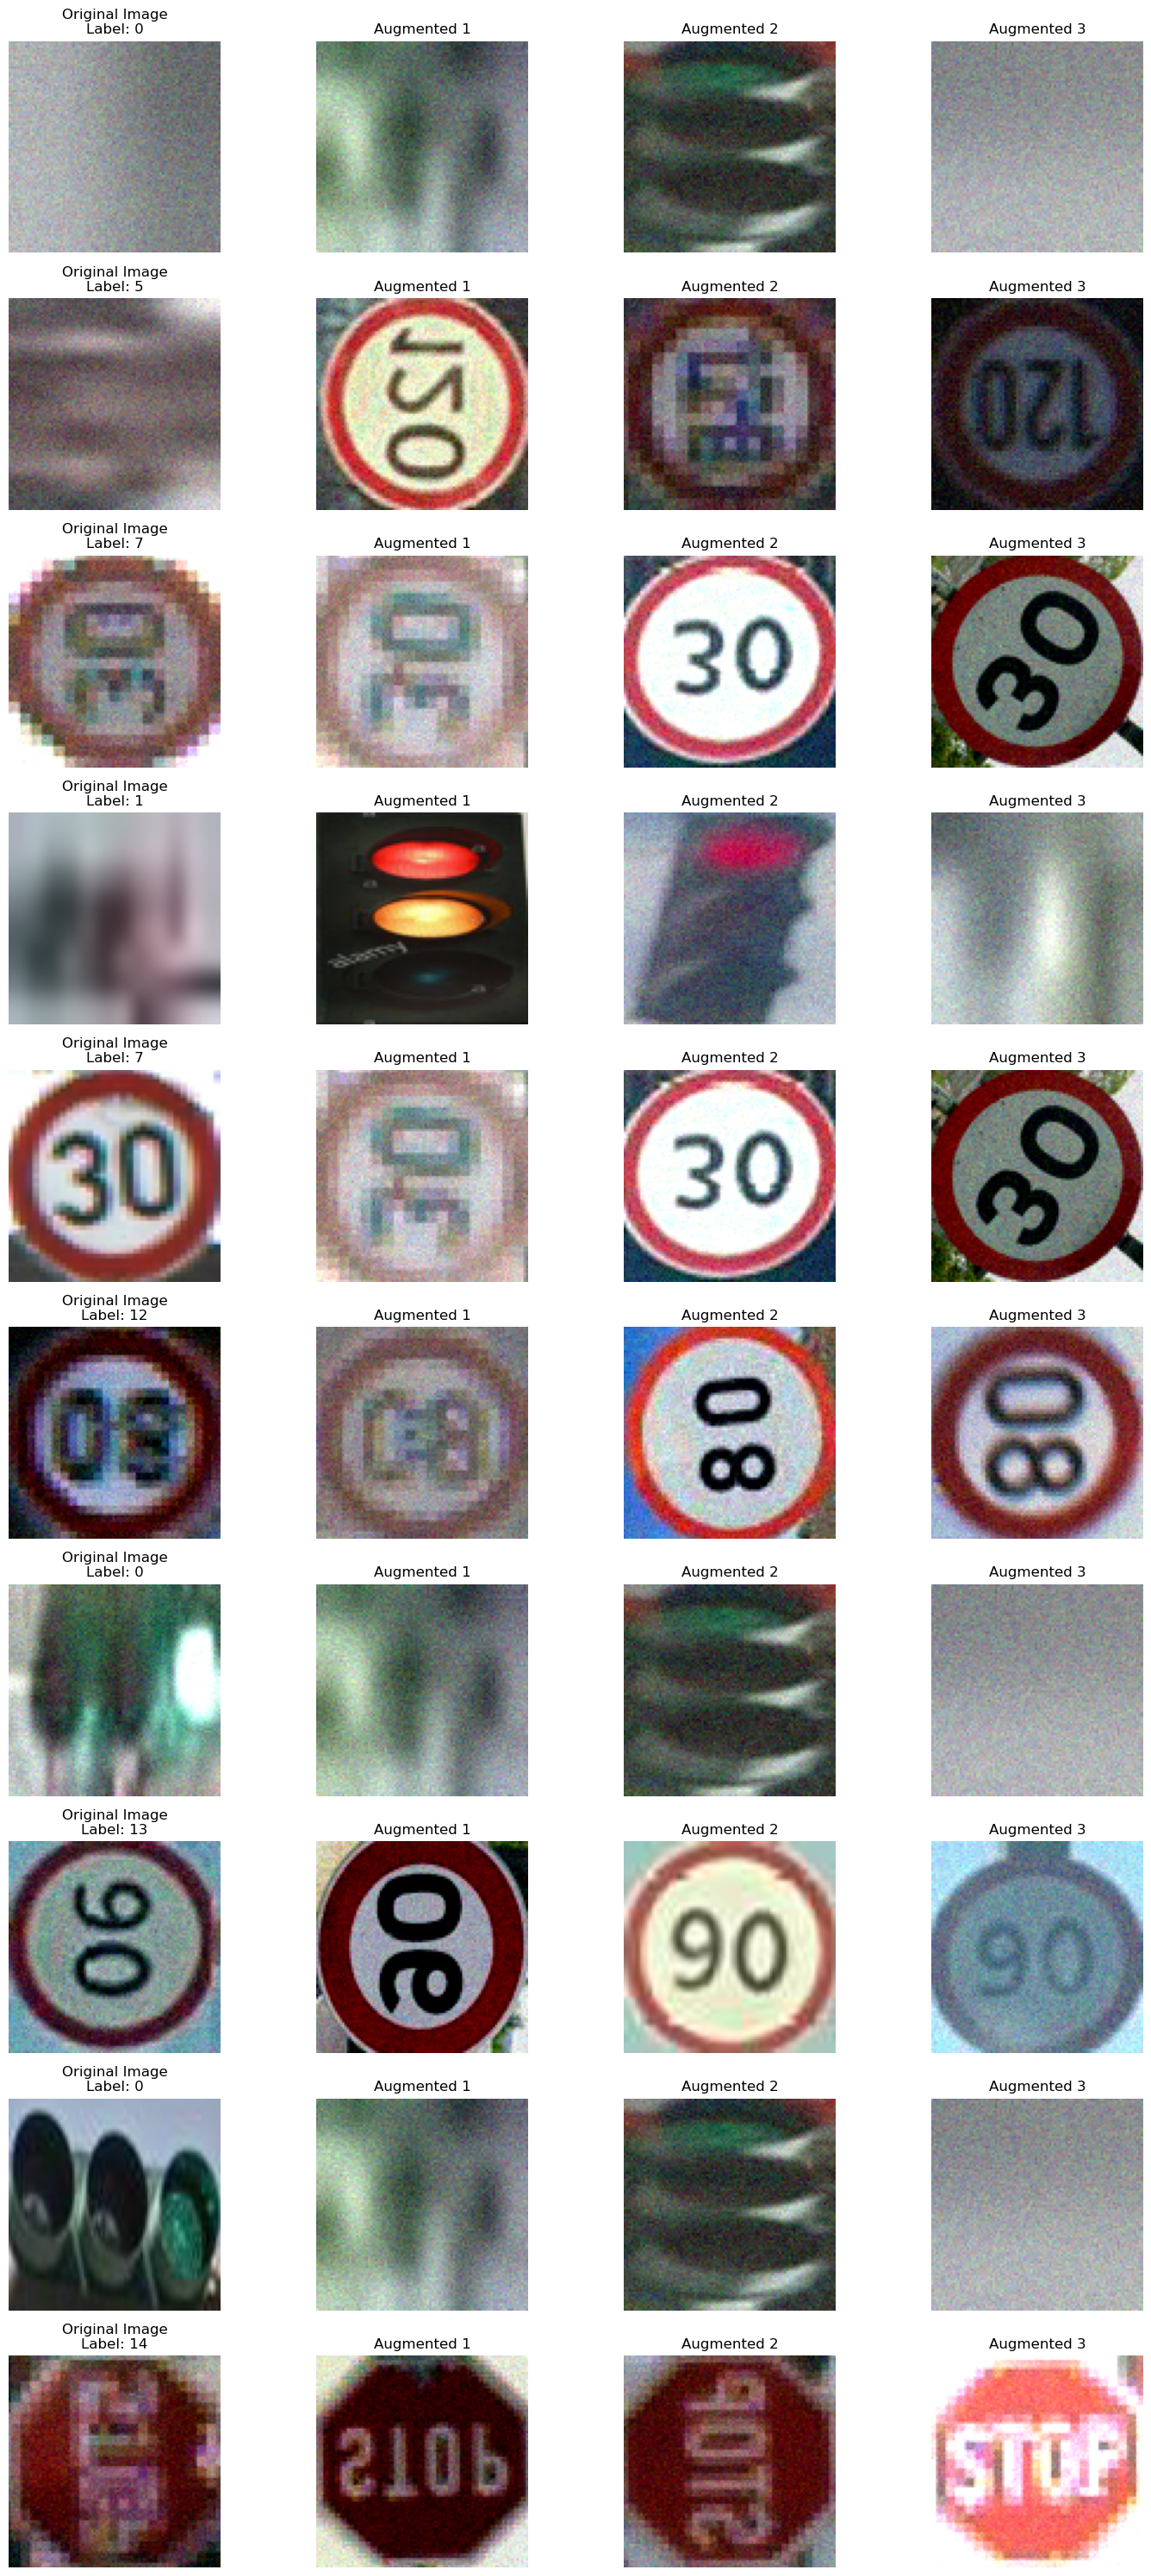

In [43]:
visualize_augmentations(augmented_train_data)



In [44]:
# Prepare augmented training data
training_data_features, training_data_labels = zip(*augmented_train_data)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)
training_data_features = training_data_features.reshape(-1, 90, 90, 3)

In [45]:
# Verify normalization
print("Feature range:", training_data_features.min(), training_data_features.max())
print("Number of augmented samples:", len(training_data_features))

Feature range: 0.0 1.0
Number of augmented samples: 17192


In [46]:
# Prepare training data features and labels
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)


training_data_features = training_data_features.astype(np.float32) / 255.0

# Reshape for CNN (add channel dimension)
training_data_features = training_data_features.reshape(-1, 90, 90, 3)

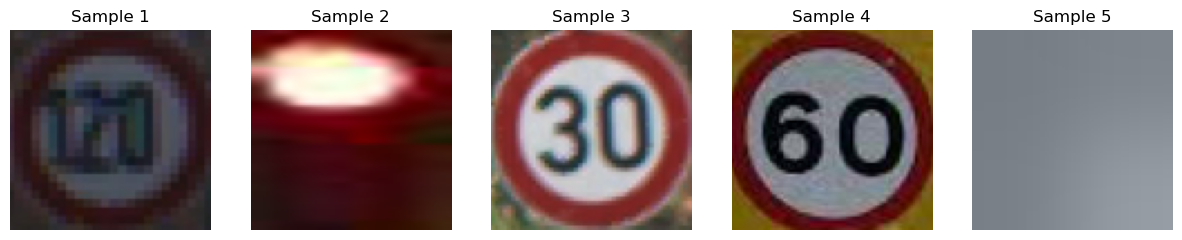

In [47]:
import matplotlib.pyplot as plt
import random

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    random_idx = random.randint(0, len(training_data_features) - 1)
    img = training_data_features[random_idx]

    # Ensure proper scaling to 0-255
    img = (img * 255).astype(np.uint8)

    axs[i].imshow(img, cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Sample {i+1}")

plt.show()


In [15]:
training_data_labels

array([ 7,  7,  7, ..., 14, 14, 14])

In [48]:
cnnModel = keras.Sequential()

# Convolutional Block 1
cnnModel.add(Conv2D(16, (3,3), padding="same", input_shape=(90, 90, 3), activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.2))  # Dropout after the first pooling layer

# Convolutional Block 2
cnnModel.add(Conv2D(32, (3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.2))  # Dropout after the second pooling layer

# Convolutional Block 3
cnnModel.add(Conv2D(64, (5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.3))  # Dropout after third pooling layer

# Convolutional Block 4
cnnModel.add(Conv2D(128, (7,7), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.3))  # Dropout after the fourth pooling layer

# Fully Connected (Dense) Layers
cnnModel.add(Flatten())
cnnModel.add(Dense(232, activation='relu'))
cnnModel.add(Dropout(0.5))  # Dropout after Dense layer to reduce overfitting
cnnModel.add(Dense(116, activation='relu'))
cnnModel.add(Dropout(0.5))  # Dropout after second Dense layer
cnnModel.add(Dense(15, activation='softmax'))

/home/user/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
cnnModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 45, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 23, 23, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 232)            │     1,069,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 232)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 116)            │        27,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 116)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,555,959 (5.94 MB)

 Trainable params: 1,555,959 (5.94 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from keras.optimizers import Adam

cnnModel.compile(optimizer=Adam(learning_rate=0.0001), 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])


In [50]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training if no improvement for 3 consecutive epochs
    restore_best_weights=True  # Restore the best model weights after stopping
)
# Define the ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce the learning rate by half
    patience=2,          # After 2 epochs of no improvement
    min_lr=1e-6          # Set a lower bound for the learning rate
)
tensorboard_callback = TensorBoard(log_dir='./logs')


In [51]:
# Prepare validation data
validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)

# Normalize validation images
validation_data_features = validation_data_features / 255.0
validation_data_features = validation_data_features.reshape(-1, 90, 90, 3)

In [52]:


# Train the model
trafficSignNetwork = cnnModel.fit(
    training_data_features, 
    training_data_labels, 
    validation_data=(validation_data_features, validation_data_labels),
    epochs=60, 
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler, tensorboard_callback]  # Include the callbacks
)

Epoch 1/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.1020 - loss: 2.6992 - val_accuracy: 0.1970 - val_loss: 2.6612 - learning_rate: 1.0000e-04
Epoch 2/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1455 - loss: 2.6071 - val_accuracy: 0.3453 - val_loss: 2.3329 - learning_rate: 1.0000e-04
Epoch 3/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2861 - loss: 2.2617 - val_accuracy: 0.3888 - val_loss: 1.9976 - learning_rate: 1.0000e-04
Epoch 4/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3293 - loss: 2.0679 - val_accuracy: 0.3782 - val_loss: 1.9312 - learning_rate: 1.0000e-04
Epoch 5/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3451 - loss: 1.9455 - val_accuracy: 0.3962 - val_loss: 1.9018 - learning_rate: 1.0000e-04
Epoch 6/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3618 - loss: 1.9127 - val_accuracy: 0.4089 - val_loss: 1.8543 - learning_rate: 1.0000e-04
Epoch 7/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accur

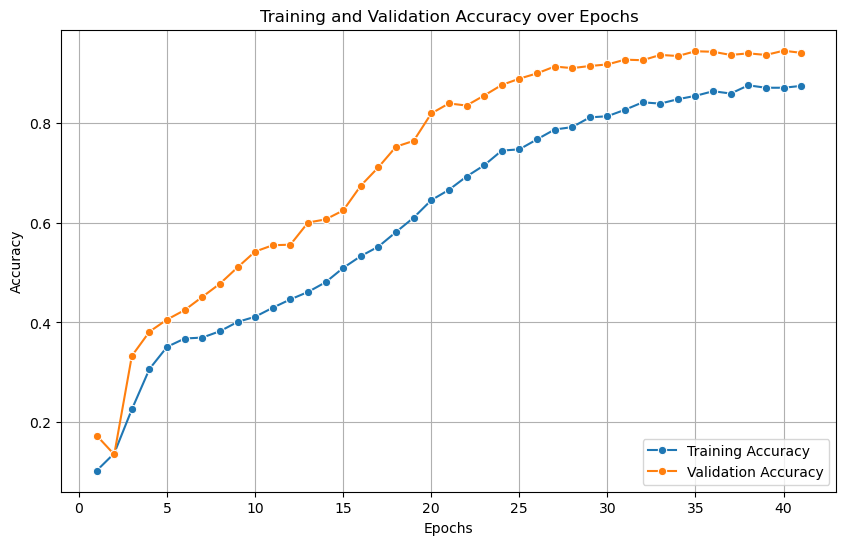

In [34]:
import seaborn as sns
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(range(1, len(trafficSignNetwork.history['accuracy']) + 1)),
             y=trafficSignNetwork.history['accuracy'],
             marker='o', label='Training Accuracy')

sns.lineplot(x=list(range(1, len(trafficSignNetwork.history['val_accuracy']) + 1)),
             y=trafficSignNetwork.history['val_accuracy'],
             marker='o', label='Validation Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

In [35]:
test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features)
test_data_labels = np.array(test_data_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 


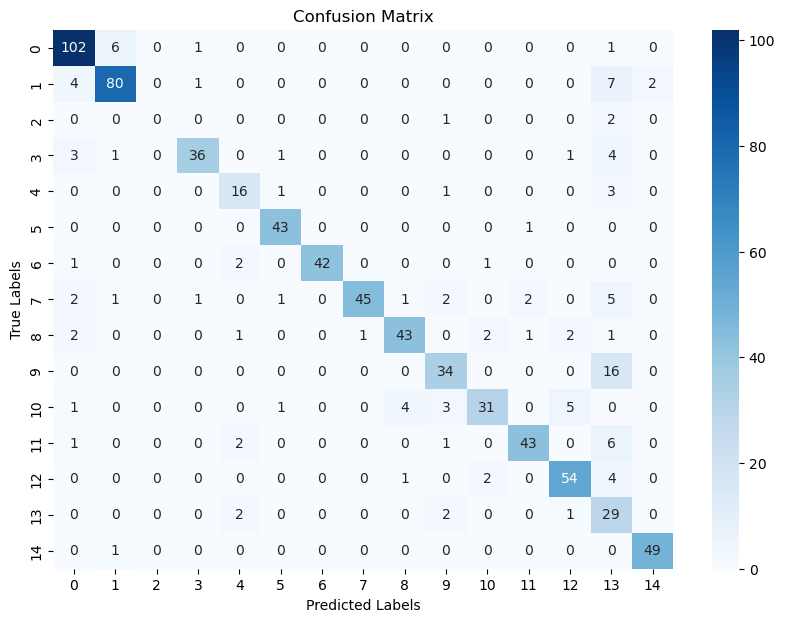

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels on the test data
test_predictions = cnnModel.predict(test_data_features)
# Convert predictions from probabilities to class labels (use argmax to get the index of the highest probability)
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [37]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       110
           1       0.90      0.85      0.87        94
           2       0.00      0.00      0.00         3
           3       0.92      0.78      0.85        46
           4       0.70      0.76      0.73        21
           5       0.91      0.98      0.95        44
           6       1.00      0.91      0.95        46
           7       0.98      0.75      0.85        60
           8       0.88      0.81      0.84        53
           9       0.77      0.68      0.72        50
          10       0.86      0.69      0.77        45
          11       0.91      0.81      0.86        53
          12       0.86      0.89      0.87        61
          13       0.37      0.85      0.52        34
          14       0.96      0.98      0.97        50

    accuracy                           0.84       770
   macro avg       0.79      0.78      0.78       770
weighted avg       0.87   

/home/user/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  # sum of the column - TP
    fn = cm[i, :].sum() - tp  # sum of the row - TP
    tn = cm.sum() - (tp + fp + fn)
    
    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


Class 0:
True Positive (TP): 102
False Positive (FP): 14
False Negative (FN): 8
True Negative (TN): 646
Precision: 0.8793
Recall: 0.9273
F1-Score: 0.9027
Accuracy: 0.9714

Class 1:
True Positive (TP): 80
False Positive (FP): 9
False Negative (FN): 14
True Negative (TN): 667
Precision: 0.8989
Recall: 0.8511
F1-Score: 0.8743
Accuracy: 0.9701

Class 2:
True Positive (TP): 0
False Positive (FP): 0
False Negative (FN): 3
True Negative (TN): 767
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Accuracy: 0.9961

Class 3:
True Positive (TP): 36
False Positive (FP): 3
False Negative (FN): 10
True Negative (TN): 721
Precision: 0.9231
Recall: 0.7826
F1-Score: 0.8471
Accuracy: 0.9831

Class 4:
True Positive (TP): 16
False Positive (FP): 7
False Negative (FN): 5
True Negative (TN): 742
Precision: 0.6957
Recall: 0.7619
F1-Score: 0.7273
Accuracy: 0.9844

Class 5:
True Positive (TP): 43
False Positive (FP): 4
False Negative (FN): 1
True Negative (TN): 722
Precision: 0.9149
Recall: 0.9773
F1-Score: 0.

In [40]:
cnnModel.save("models/model_v4.keras")
